<h1 style="padding:50px; color:white; background:#07D; font-size:48px; text-align:center; font-weight:bold;">
    Projet - OUTINFO
</h1>

In [10]:
import numpy as np # import du package 'numpy' avec alias 'np'
import pandas as pd # import du package 'pandas' avec alias 'pd'
from SRC.tools import show, inspect  # import des fonctions du module 'tools'
from IPython.core.interactiveshell import InteractiveShell as ish

import matplotlib.pyplot as mp # import du package 'matplotlib' avec alias 'mp'
import seaborn as sb # import du package 'seaborn' avec alias 'sb'

from SRC.tools import show, load, fetch

import warnings; warnings.filterwarnings('ignore') # on enlève les 'warning' éventuels


<h2 style="padding:16px; color:white; background:#07D">Travail envisagé</h2>

**Données:**

- https://public.opendatasoft.com/explore/dataset/medecins/information/?flg=fr&location=8,48.49659,1.94733&basemap=jawg.light

Liste, localisation et tarifs des professionnels de santé en France. 

Format : GeoJSON

<br>

- https://statistiques-locales.insee.fr/#c=indicator&i=filosofi.nbmenfisc&i2=filosofi.pimp&s=2021&s2=2021&selcodgeo=04&t=A01&t2=A01&view=map2

Statistiques locales en France: nombre d'habitants par zone, niveau de vie moyen par zone, espérance de vie, répartition de la population par âge, etc.

Format : CSV  
<br>

- https://www.regions-et-departements.fr/

Départements associés à leur région. \
Téléchargement des données en format PDF puis utilisation d'un convertisseur en ligne afin d'obtenir les données en format HTML.

Format : HTML

<br>
  
- https://www.openstreetmap.fr/

Les adjacences des communes françaises (avec une requête sql)

<br>



**Analyses envisagées:**

- Concentration des medecins par departement

- Comparer la concentration entre les zones rurales et urbaines

- Calculer le nombre de patient par medecin, à l'aide de leur localisation et de l'adjacence des communes

- Le montant constaté par séance par medecin par patient, et le niveau de revenu moyen de ses patients

<br> <br>

<h2 style="padding:16px; color:white; background:#07D">Etape 1 - Maillon fetch</h2>

<br> <br>

---
### 1 - Statistiques locales en France

<br>
Le fichier a été téléchargé, puis déposé sur GitHub, pour pouvoir y accéder à l'aide d'un url.

Les séparateurs sont '$;$' et les deux premières lignes sont à ignorer.

In [2]:
import pandas as pd
import requests
from io import StringIO

# URL GitHub pour le fichier CSV
url = "https://raw.githubusercontent.com/ahina0/projet_outinfo/main/statistiques.csv"

# Télécharger le fichier CSV depuis GitHub
response = requests.get(url)
response.raise_for_status()
    
# Charger les données dans un DataFrame
statistiques = pd.read_csv(StringIO(response.text), sep=';', skiprows=2)
statistiques

,Code,Libellé,Médecin généraliste (en nombre) 2023,Salaire net horaire moyen 2022,Chirurgien dentiste (en nombre) 2023,Population municipale 2022,Estimations de population 2024,Nb de pers. âgées de 65 ans ou + 2021,Nb de ménages fiscaux 2021,Médiane du niveau de vie 2021
0,01,Ain,435,15.96,321,671289,679498,121906,270138,24810
1,02,Aisne,372,14.46,226,525558,521632,111675,224492,20920
2,03,Allier,278,14.19,168,334715,332708,94477,160041,21500
3,04,Alpes-de-Haute-Provence,169,14.6,90,167179,168161,44383,72855,21790
4,05,Hautes-Alpes,182,13.99,89,141677,141661,36270,65683,22010
...,...,...,...,...,...,...,...,...,...,...
96,971,Guadeloupe,322,15.21,207,383569,378561,78607,N/A - résultat non disponible,N/A - résultat non disponible
97,972,Martinique,330,15.02,215,361019,349925,80027,147620,19770
98,973,Guyane,117,15.43,81,288382,295385,17149,N/A - résultat non disponible,N/A - résultat non disponible
99,974,La Réunion,857,14.26,539,881348,885700,112104,334396,17070


<br>

---
### 2 - Les départements et leur région

<br>

Le fichier a été téléchargé, puis déposé sur GitHub, pour pouvoir y accéder à l'aide d'un url. \
On récupère les données du fichier HTML qu'on enregistre dans un data frame. \
La première ligne du fichier HTML est le nom des colonnes, on l'utilise donc. On ne renomme pas la première colonne car on ne l'utilisera pas.

In [22]:
from bs4 import BeautifulSoup

# URL GitHub pour le fichier CSV
url = "https://raw.githubusercontent.com/ahina0/projet_outinfo/main/regions-et-departements-francais-converted.html"

# Télécharger le fichier HTML depuis GitHub
response = requests.get(url)
response.raise_for_status()


soup = BeautifulSoup(response.text, 'html.parser')

# step 2: identify the tags containing the data
# assume the data is in <tr> tags with <td> for each column
rows = soup.find_all('tr')

# step 3: extract and structure the data
data = []
for row in rows:
    cells = row.find_all('td')
    if len(cells) == 3:  # Number, Department, Region
        num = cells[0].get_text(strip=True)        # Number
        dept = cells[1].get_text(strip=True)       # Department
        region = cells[2].get_text(strip=True)     # Region
        data.append([num, dept, region])

# step 4: create a DataFrame with the extracted data
dept_region = pd.DataFrame(data)
dept_region.columns = dept_region.iloc[0]
dept_region = dept_region[1:].reset_index(drop=True)
dept_region

,‌NUMÉRODépartement,DÉPARTEMENT,RÉGION
0,01,Ain,Auvergne-Rhône-Alpes
1,02,Aisne,Hauts-de-France
2,03,Allier,Auvergne-Rhône-Alpes
3,04,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur
4,05,Hautes-Alpes,Provence-Alpes-Côte d'Azur
...,...,...,...
96,971,Guadeloupe,Guadeloupe
97,972,Martinique,Martinique
98,973,Guyane,Guyane
99,974,La Réunion,La Réunion


<br>

---
### 3 - Liste, localisation et tarifs des professionnels de santé en France.

<br>

Le fichier était trop lourd pour être téléchargé, et un url est directement disponible depuis la page web pour accéder à ces données. On utilise donc cet url. On a aussi uniquement sélectionné les données correspondant à "médecin généraliste", pour que le fichier soit moins lourd.

Comme le fichier est lourd, cette cellule est longue à s'exécuter.

In [128]:
import requests
import geopandas as gpd
from io import StringIO

# URL du fichier GeoJSON
url = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/medecins/exports/geojson?lang=fr&refine=libelle_profession%3A%22M%C3%A9decin%20g%C3%A9n%C3%A9raliste%22&timezone=Europe%2FBerlin"

# Télécharger le fichier GeoJSON
response = requests.get(url, stream=True)

# Charger le GeoJSON dans GeoPandas
geojson_data = response.text
professionnels_sante = gpd.read_file(StringIO(geojson_data))

# Afficher les premières lignes
professionnels_sante

Skipping field libelle_acte_clinique: unsupported OGR type: 5


,civilite,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,...,libelle_activite,libelle,tarif_1,tarif_2,remboursement,exoneration_tm,libelle_phase,tarif_base_de_remboursement_securite_sociale,concat,geometry
0,Homme,04.92.43.46.74,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,NZLH0020,13.0,...,Opérateur Principal,Injection thérapeutique d'agent pharmacologiqu...,19.18,14.4,None,1.0,Une seule phase de traitement,19.18,IVAN PROTHOYPOLYCLINIQUE DES ALPES DU SUD 3 RU...,POINT (6.07079 44.56808)
1,Femme,04.92.53.02.00,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,GS,NaN,...,None,None,None,None,None,NaN,None,NaN,SOPHIE VIGNAT 4A COURS EMILE ZOLA 05000 GAP,POINT (6.07412 44.5538)
2,Homme,04.92.57.76.13,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,DEQP0030,103.0,...,Opérateur Principal,Électrocardiographie sur au moins 12 dérivations,14.52,13.66,None,2.0,Une seule phase de traitement,14.52,JEAN CHRISTIAN GRIMMONPREZ 7 A-B R CAPITAINE B...,POINT (6.08263 44.55919)
3,Femme,04.92.51.62.23,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,G,NaN,...,None,None,None,None,None,NaN,None,NaN,ANNE LINE MEYER 27 RUE DU FOREST D'ENTRAIS 0...,POINT (6.09093 44.57099)
4,Homme,04.92.52.33.33,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,EBQM0030,92.0,...,Opérateur Principal,Échographie-doppler des vaisseaux cervicocépha...,95.33,95.33,None,2.0,Une seule phase de traitement,95.33,YANN ROUSSIN BOUCHARDSELIANCE 5 IMPASSE DE BO...,POINT (6.08351 44.56261)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263386,Femme,03.22.92.98.34,45,Acupuncteur,Libéral intégral,"Secteur 2, Signature du contrat d'accès aux soins",O,Lecteur de carte Sesam Vitale,G,NaN,...,None,None,None,None,None,NaN,None,NaN,GENEVIEVE DIDELET 93 RUE VATABLE 80090 AMIENS,POINT (2.32052 49.88436)
263387,Femme,03.22.48.00.00,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,G,NaN,...,None,None,None,None,None,NaN,None,NaN,MARIE CLAIRE MASQUELIER MAISON DE SANTE PLACE ...,POINT (2.52474 50.0125)
263388,Femme,03.22.88.49.50,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,CCE,NaN,...,None,None,None,None,None,NaN,None,NaN,ANGELIQUE DEBEAULIEU MSP DE CONTOIRE HAMEL 104...,POINT (2.547 49.72177)
263389,Homme,03.22.51.45.64,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,G,NaN,...,None,None,None,None,None,NaN,None,NaN,PIERRE CHARRIERCABINET MEDICAL 3 PLACE DE L E...,POINT (2.14993 49.95316)


### <br> <br>

<h2 style="padding:16px; color:white; background:#07D">Etape 2 - Maillons clean et structure</h2>

<br> <br>

---
### 1 -  Statistiques locales en France. 

<br>

Le nombre de chirurgiens dentistes n'est d'aucune utilité, car les chirurgiens dentistes ne figurent pas dans la database sur les professionnels de santé. On supprime donc cette colonne.

In [3]:
statistiques = statistiques.drop(columns=["Chirurgien dentiste (en nombre) 2023"]) # drop the specified column
statistiques.head() # display the first rows

,Code,Libellé,Médecin généraliste (en nombre) 2023,Salaire net horaire moyen 2022,Population municipale 2022,Estimations de population 2024,Nb de pers. âgées de 65 ans ou + 2021,Nb de ménages fiscaux 2021,Médiane du niveau de vie 2021
0,01,Ain,435,15.96,671289,679498,121906,270138,24810
1,02,Aisne,372,14.46,525558,521632,111675,224492,20920
2,03,Allier,278,14.19,334715,332708,94477,160041,21500
3,04,Alpes-de-Haute-Provence,169,14.6,167179,168161,44383,72855,21790
4,05,Hautes-Alpes,182,13.99,141677,141661,36270,65683,22010


<br>

---
### 2 -  Les départements et leur région

<br>

On ajoute la colonne des régions à la data frame des statistiques locales françaises. Les départements sont déjà dans l'ordre croissant de leur numéro dans les deux data frame, donc aucune manipulation supplémentaire n'est nécéssaire.


In [26]:
statistiques['Région'] = dept_region.RÉGION # the "RÉGION" column in dept_region is added to statistiques
statistiques.head() #display the first rows

,Code,Libellé,Médecin généraliste (en nombre) 2023,Salaire net horaire moyen 2022,Population municipale 2022,Nb de pers. âgées de 65 ans ou + 2021,Nb de ménages fiscaux 2021,Médiane du niveau de vie 2021,Région
0,01,Ain,435,15.96,671289,121906,270138,24810,Auvergne-Rhône-Alpes
1,02,Aisne,372,14.46,525558,111675,224492,20920,Hauts-de-France
2,03,Allier,278,14.19,334715,94477,160041,21500,Auvergne-Rhône-Alpes
3,04,Alpes-de-Haute-Provence,169,14.6,167179,44383,72855,21790,Provence-Alpes-Côte d'Azur
4,05,Hautes-Alpes,182,13.99,141677,36270,65683,22010,Provence-Alpes-Côte d'Azur


<br>

---
### 3 -  Liste, localisation et tarifs des professionnels de santé en France. 

<br>

Les colonnes ayant un nom de type "column_*number*" ne sont pas gardées.

In [129]:
# keep only columns that do not match the pattern 'column_"number"'
filtered_columns = [col for col in professionnels_sante.columns if not col.startswith("column_")]
professionnels_sante = professionnels_sante[filtered_columns]

professionnels_sante.head()

,civilite,nom,adresse,libelle_profession,type_dacte_realise,nom_acte,coordonnees,commune,code_insee,epci_name,...,libelle_activite,libelle,tarif_1,tarif_2,remboursement,exoneration_tm,libelle_phase,tarif_base_de_remboursement_securite_sociale,concat,geometry
0,Homme,IVAN PROTHOY,POLYCLINIQUE DES ALPES DU SUD 3 RUE ANTONIN CO...,Médecin généraliste,Acte technique,Actes médicaux sur les articulations pour évac...,None,Gap,05061,Communauté d'agglomération Gap-Tallard-Durance,...,Opérateur Principal,Injection thérapeutique d'agent pharmacologiqu...,19.18,14.4,None,1.0,Une seule phase de traitement,19.18,IVAN PROTHOYPOLYCLINIQUE DES ALPES DU SUD 3 RU...,POINT (6.07079 44.56808)
1,Femme,SOPHIE VIGNAT,4A COURS EMILE ZOLA 05000 GAP,Médecin généraliste,Acte clinique,None,None,Gap,05061,Communauté d'agglomération Gap-Tallard-Durance,...,None,None,None,None,None,NaN,None,NaN,SOPHIE VIGNAT 4A COURS EMILE ZOLA 05000 GAP,POINT (6.07412 44.5538)
2,Homme,JEAN CHRISTIAN GRIMMONPREZ,7 A-B R CAPITAINE BRESSON RESIDENCE LE PARC 0...,Médecin généraliste,Acte technique,"Électrocardiogramme (ECG),",None,Gap,05061,Communauté d'agglomération Gap-Tallard-Durance,...,Opérateur Principal,Électrocardiographie sur au moins 12 dérivations,14.52,13.66,None,2.0,Une seule phase de traitement,14.52,JEAN CHRISTIAN GRIMMONPREZ 7 A-B R CAPITAINE B...,POINT (6.08263 44.55919)
3,Femme,ANNE LINE MEYER,27 RUE DU FOREST D'ENTRAIS 05000 GAP,Médecin généraliste,Acte clinique,None,None,Gap,05061,Communauté d'agglomération Gap-Tallard-Durance,...,None,None,None,None,None,NaN,None,NaN,ANNE LINE MEYER 27 RUE DU FOREST D'ENTRAIS 0...,POINT (6.09093 44.57099)
4,Homme,YANN ROUSSIN BOUCHARD,SELIANCE 5 IMPASSE DE BONNE 05000 GAP,Médecin généraliste,Acte technique,Echodoppler des artères (hors artères intratho...,None,Gap,05061,Communauté d'agglomération Gap-Tallard-Durance,...,Opérateur Principal,Échographie-doppler des vaisseaux cervicocépha...,95.33,95.33,None,2.0,Une seule phase de traitement,95.33,YANN ROUSSIN BOUCHARDSELIANCE 5 IMPASSE DE BO...,POINT (6.08351 44.56261)


<br>

On ne garde que les colonnes qui nous intéressent pour les analyses.

On visualise les colonnes restantes :

In [131]:
professionnels_sante.columns # visualisation of the remaining columns

Index(['civilite', 'nom', 'adresse', 'libelle_profession',
       'type_dacte_realise', 'nom_acte', 'coordonnees', 'commune',
       'code_insee', 'epci_name', 'dep_name', 'reg_name', 'epci_code',
       'reg_code', 'dep_code', 'activite_principale', 'code', 'phase',
       'libelle_regroupement', 'accord_prealable', 'code_ccam_activite_phase',
       'regroupement', 'libelle_activite', 'libelle', 'tarif_1', 'tarif_2',
       'remboursement', 'exoneration_tm', 'libelle_phase',
       'tarif_base_de_remboursement_securite_sociale', 'concat', 'geometry'],
      dtype='object')

<br>

La colonne "libelle_profession" est inutile, car on a conservé que les lignes qui correspondent aux médecins généralistes dans la base de données initiale.

Pour plus de complexité à traiter les données, on décide de ne pas conserver les colonnes de la commune, du département et de la région. On créera la colonne du département à partir de la colonne adresse.

Le nom du médecin, le type d'acte réalisé et autres informations sur l'activité du médecin ne nous interesse pas.

On ne conserve donc que les colonnes sur le genre du médecin, l'adresse, et le tarif de la consultation.

In [132]:
columns_to_keep = ["civilite", "adresse", "tarif_1", "tarif_2", "remboursement", "tarif_base_de_remboursement_securite_sociale"] # the columns to keep
professionnels_sante = professionnels_sante[columns_to_keep]

professionnels_sante.head(20)

,civilite,adresse,tarif_1,tarif_2,remboursement,tarif_base_de_remboursement_securite_sociale
0,Homme,POLYCLINIQUE DES ALPES DU SUD 3 RUE ANTONIN CO...,19.18,14.4,None,19.18
1,Femme,4A COURS EMILE ZOLA 05000 GAP,None,None,None,NaN
2,Homme,7 A-B R CAPITAINE BRESSON RESIDENCE LE PARC 0...,14.52,13.66,None,14.52
3,Femme,27 RUE DU FOREST D'ENTRAIS 05000 GAP,None,None,None,NaN
4,Homme,SELIANCE 5 IMPASSE DE BONNE 05000 GAP,95.33,95.33,None,95.33
5,Homme,CABINET DU DR FRIEDERICH PLACE DU VILLAGE CABI...,14.52,13.66,None,14.52
6,Homme,CABINET DU DR FRIEDERICH PLACE DU VILLAGE CABI...,29.68,25.99,None,29.68
7,Homme,133 RUE DES ECOLES 05230 LA BATIE NEUVE,None,None,None,NaN
8,Femme,230 AVENUE DE LA CALIFORNIE 06200 NICE,41.8,41.8,None,41.80
9,Femme,4 AVENUE DE L EST 06220 VALLAURIS,None,None,None,NaN


<br>

On remarque que beaucoup de valeurs de la colonne "remboursement" semblent avoir la valeur "None". On compte le nombre de ces valeurs pour décider de garder cette colonne ou non.

Pourcentage de valeurs None dans la colonne remboursement : 99%.


<Axes: xlabel='remboursement'>

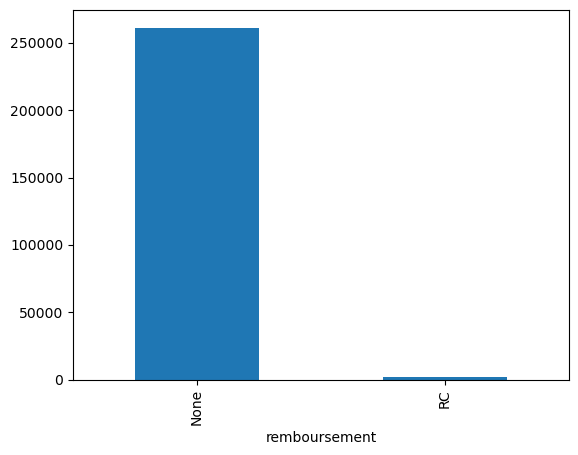

In [133]:
# count the number of None values in the "remboursement" column. It is either Na or "None"
none_count = professionnels_sante[(professionnels_sante["remboursement"].isna()) | (professionnels_sante["remboursement"] == "None")].shape[0]
total_rows = professionnels_sante.shape[0] # count the number of rows in the dataframe
print(f"Pourcentage de valeurs None dans la colonne remboursement : {(none_count/total_rows)*100:.0f}%.") # prints the percentage of None values, with no decimal

professionnels_sante["remboursement"] = professionnels_sante["remboursement"].fillna("None") # if Na, write "None"
# display the repartition of the values of the remboursement column
professionnels_sante.groupby("remboursement").count()["civilite"].plot.bar()

On décide de supprimer cette colonne.

In [134]:
professionnels_sante = professionnels_sante.drop(columns=["remboursement"])
professionnels_sante.head()

,civilite,adresse,tarif_1,tarif_2,tarif_base_de_remboursement_securite_sociale
0,Homme,POLYCLINIQUE DES ALPES DU SUD 3 RUE ANTONIN CO...,19.18,14.4,19.18
1,Femme,4A COURS EMILE ZOLA 05000 GAP,None,None,NaN
2,Homme,7 A-B R CAPITAINE BRESSON RESIDENCE LE PARC 0...,14.52,13.66,14.52
3,Femme,27 RUE DU FOREST D'ENTRAIS 05000 GAP,None,None,NaN
4,Homme,SELIANCE 5 IMPASSE DE BONNE 05000 GAP,95.33,95.33,95.33


In [ ]:
Les colonnes tarif_1 et tarif_2 

In [ ]:
Calcul de la moyenne du nombre de médecins généralistes par régions en 2023

In [7]:
df = pd.DataFrame(table)

# Calcul de la moyenne du nombre de médecins généralistes par région
moyennes_par_region = df.groupby("Région")["Médecin généraliste (en nombre) 2023"].mean()

# Affichage des résultats
print(moyennes_par_region)


Région
Auvergne-Rhône-Alpes           606.333333
Bourgogne-Franche-Comté        210.375000
Bretagne                       548.750000
Centre-Val de Loire            293.333333
Corse                          484.500000
Grand Est                      488.700000
Guadeloupe                     322.000000
Guyane                         117.000000
Hauts-de-France               1024.600000
Ile-de-France                 1135.250000
La Réunion                     857.000000
Martinique                     330.000000
Mayotte                         31.000000
Normandie                      649.800000
Nouvelle-Aquitaine             552.166667
Occitanie                      451.769231
Pays de la Loire               632.800000
Provence-Alpes-Côte d'Azur     984.500000
Name: Médecin généraliste (en nombre) 2023, dtype: float64


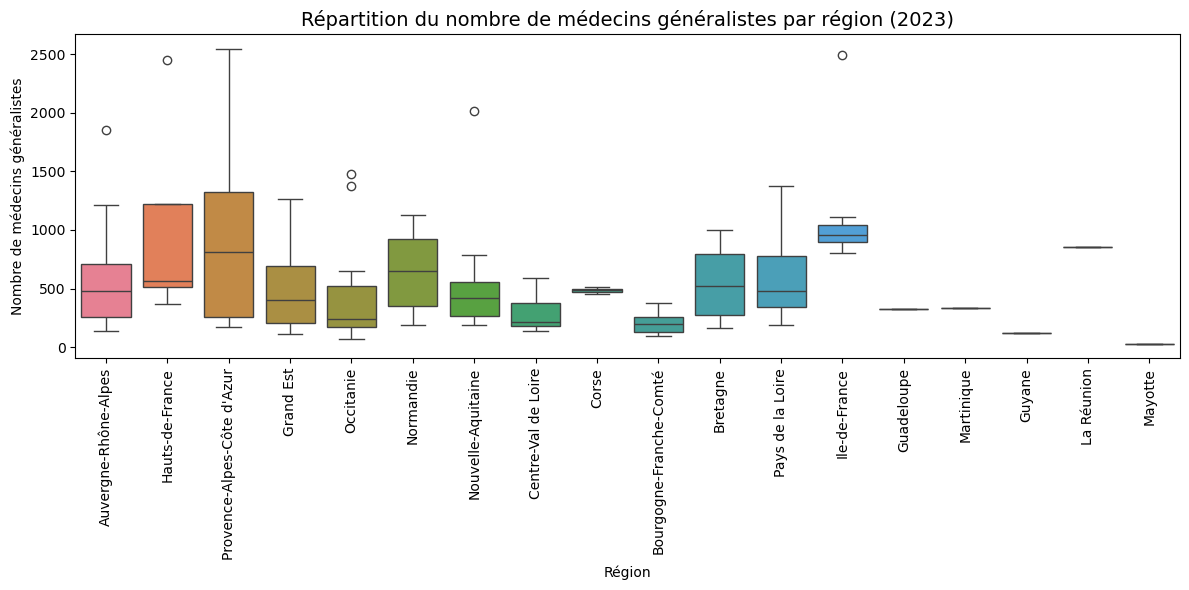

In [11]:
# Créer le graphique en boîtes à moustaches avec des couleurs différentes
mp.figure(figsize=(12, 6))
palette = sb.color_palette("husl", len(table["Région"].unique()))  # Génère une palette de couleurs unique

sb.boxplot(
    x="Région",
    y="Médecin généraliste (en nombre) 2023",
    data=table,
    palette=palette
)

# Personnalisation du graphique
mp.title("Répartition du nombre de médecins généralistes par région (2023)", fontsize=14)
mp.xticks(rotation=90)
mp.xlabel("Région")
mp.ylabel("Nombre de médecins généralistes")
mp.tight_layout()

# Afficher le graphique
mp.show()
